目的：OCT2Ageモデルを開発し、年齢予測に寄与するグリッドを可視化する

# Libraries

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd; pd.set_option('display.max_columns', None)

import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()
%precision 3

# utility
import sys
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import pickle
import openpyxl as px
import xlrd
from functools import reduce

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# ローカルライブラリ
%cd /users/keimy/git/OCT2Age
import src.archetypes as arch

/Users/keimy/git/OCT2Age


# Preprocess Data

In [2]:
from src.preprocess import make_datasets_in_2016

df_cpRNFL, OCT_cpRNFL = make_datasets_in_2016(filenames=["cpRNFL2016.csv"], ROI="cpRNFL")
df_mRNFL, OCT_mRNFL = make_datasets_in_2016(filenames=["mRNFL2016.csv"], ROI="mRNFL")
df_mGCLP, OCT_mGCLP = make_datasets_in_2016(filenames=["mGCLP2016.csv"], ROI="mGCLP")

dfs = [df_cpRNFL, df_mRNFL, df_mGCLP]
df = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs)

dfs_OCT = [OCT_cpRNFL, OCT_mRNFL, OCT_mGCLP]
df_OCT = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs_OCT)

df.shape, df_OCT.shape


((7666, 430), (7666, 215))

In [3]:
# df_kenshin = pd.read_csv("../data_kenshin/h2016.csv")
df_kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); df_kenshin.drop(index=0, inplace=True)
df_kenshin = df_kenshin.rename(columns={"kenshinID": "ID" })
df_kenshin = df_kenshin.reset_index(drop=True)

# 日付型のdate変数を作成
df_OCT['date'] = pd.to_datetime(df_OCT['topID'].astype(str).str[-8:])
df_kenshin['date'] = pd.to_datetime(df_kenshin['kenshindate'].astype(str))

# IDを文字列型に変換
df_OCT['ID'] = df_OCT['ID'].astype(str)
df_kenshin['ID'] = df_kenshin['ID'].astype(str)

# IDとdateを使ってOCTとkenshinをマージ
df_merged = pd.merge(df_OCT, df_kenshin, on=['ID', 'date'], how='left')

# df_mergedの前処理
# 年齢の欠損を除外
df_merged = df_merged[df_merged['age'].notnull()]

# 問診項目の変数処理
def conversion_to_int(df, filling):
    df2 = pd.to_numeric(df, errors='coerce')
    df2.fillna(1, inplace=True)  # 例: 0で置換
    df2 = df2.astype(np.int64)
    return df2

df_merged["smoking"] = (conversion_to_int(df_merged["mon3x1x1"], 1) != 1).astype(int)
df_merged["drinking"] = (conversion_to_int(df_merged["mon3x2x1"], 0) != 0).astype(int)
df_merged["exercise"] = (conversion_to_int(df_merged["mon5x4x1"], 1) != 1).astype(int)

df_merged["sleep"] = conversion_to_int(df_merged["mon2x2"], 9)
df_merged["short_sleep_6"] = ((df_merged.sleep == 1) | (df_merged.sleep == 2)).astype(int)
df_merged["short_sleep_5"] = (df_merged.sleep == 1).astype(int)


len(df_merged)

/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_96715/2409096987.py:2: DtypeWarning: Columns (86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,106,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,130,133,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,187,188,189,190,191,192,193,194,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); df_kenshin.drop(index=0, inplace=True)


7662

In [21]:
from src.preprocess import create_scaled_dataloader_per_CV, dataframe_to_tensor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer

def split_dataframe(df, var_name):
    # OCT情報とageだけを残す
    col_names = df_OCT.columns.tolist() + [var_name]
    XY_df = df[col_names]

    # X_df は 'ID', 'topID', 'eye', 'date', 'age' を除くすべての列を含む
    X_df = XY_df.drop(['ID', 'topID', 'eye', 'date', var_name], axis=1)

    # y_df は 'age' 列のみを含む
    y_df = XY_df[[var_name]]

    return X_df, y_df


# X,Yにスプリット
var_name = "age"
X_df, y_df = split_dataframe(df_merged, var_name=var_name)

# データローダーの作成
n_splits = 3
batch_size = 32

# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = FunctionTransformer()

_, X_test_CV, X_scaler_CV, _, y_test_CV, y_scaler_CV, train_loader_CV, test_loader_CV = create_scaled_dataloader_per_CV(X_df, y_df, scaler=scaler, n_splits=n_splits, batch_size=batch_size)

# Data Distribution in 2D

In [5]:
df_merged.head(1)

,ID,topID,eye,cpRNFL_T,cpRNFL_TS,cpRNFL_ST,cpRNFL_S,cpRNFL_SN,cpRNFL_NS,cpRNFL_N,cpRNFL_NI,cpRNFL_IN,cpRNFL_I,cpRNFL_IT,cpRNFL_TI,mRNFL_01_01,mRNFL_02_01,mRNFL_03_01,mRNFL_04_01,mRNFL_05_01,mRNFL_06_01,mRNFL_07_01,mRNFL_08_01,mRNFL_09_01,mRNFL_10_01,mRNFL_01_02,mRNFL_02_02,mRNFL_03_02,mRNFL_04_02,mRNFL_05_02,mRNFL_06_02,mRNFL_07_02,mRNFL_08_02,mRNFL_09_02,mRNFL_10_02,mRNFL_01_03,mRNFL_02_03,mRNFL_03_03,mRNFL_04_03,mRNFL_05_03,mRNFL_06_03,mRNFL_07_03,mRNFL_08_03,mRNFL_09_03,mRNFL_10_03,mRNFL_01_04,mRNFL_02_04,mRNFL_03_04,mRNFL_04_04,mRNFL_05_04,mRNFL_06_04,mRNFL_07_04,mRNFL_08_04,mRNFL_09_04,mRNFL_10_04,mRNFL_01_05,mRNFL_02_05,mRNFL_03_05,mRNFL_04_05,mRNFL_05_05,mRNFL_06_05,mRNFL_07_05,mRNFL_08_05,mRNFL_09_05,mRNFL_10_05,mRNFL_01_06,mRNFL_02_06,mRNFL_03_06,mRNFL_04_06,mRNFL_05_06,mRNFL_06_06,mRNFL_07_06,mRNFL_08_06,mRNFL_09_06,mRNFL_10_06,mRNFL_01_07,mRNFL_02_07,mRNFL_03_07,mRNFL_04_07,mRNFL_05_07,mRNFL_06_07,mRNFL_07_07,mRNFL_08_07,mRNFL_09_07,mRNFL_10_07,mRNFL_01_08,mRNFL_02_08,mRNFL_03_08,mRNFL_04_08,mRNFL_05_08,mRNFL_06_08,mRNFL_07_08,mRNFL_08_08,mRNFL_09_08,mRNFL_10_08,mRNFL_01_09,mRNFL_02_09,mRNFL_03_09,mRNFL_04_09,mRNFL_05_09,mRNFL_06_09,mRNFL_07_09,mRNFL_08_09,mRNFL_09_09,mRNFL_10_09,mRNFL_01_10,mRNFL_02_10,mRNFL_03_10,mRNFL_04_10,mRNFL_05_10,mRNFL_06_10,mRNFL_07_10,mRNFL_08_10,mRNFL_09_10,mRNFL_10_10,mGCLP_01_01,mGCLP_02_01,mGCLP_03_01,mGCLP_04_01,mGCLP_05_01,mGCLP_06_01,mGCLP_07_01,mGCLP_08_01,mGCLP_09_01,mGCLP_10_01,mGCLP_01_02,mGCLP_02_02,mGCLP_03_02,mGCLP_04_02,mGCLP_05_02,mGCLP_06_02,mGCLP_07_02,mGCLP_08_02,mGCLP_09_02,mGCLP_10_02,mGCLP_01_03,mGCLP_02_03,mGCLP_03_03,mGCLP_04_03,mGCLP_05_03,mGCLP_06_03,mGCLP_07_03,mGCLP_08_03,mGCLP_09_03,mGCLP_10_03,mGCLP_01_04,mGCLP_02_04,mGCLP_03_04,mGCLP_04_04,mGCLP_05_04,mGCLP_06_04,mGCLP_07_04,mGCLP_08_04,mGCLP_09_04,mGCLP_10_04,mGCLP_01_05,mGCLP_02_05,mGCLP_03_05,mGCLP_04_05,mGCLP_05_05,mGCLP_06_05,mGCLP_07_05,mGCLP_08_05,mGCLP_09_05,mGCLP_10_05,mGCLP_01_06,mGCLP_02_06,mGCLP_03_06,mGCLP_04_06,mGCLP_05_06,mGCLP_06_06,mGCLP_07_06,mGCLP_08_06,mGCLP_09_06,mGCLP_10_06,mGCLP_01_07,mGCLP_02_07,mGCLP_03_07,mGCLP_04_07,mGCLP_05_07,mGCLP_06_07,mGCLP_07_07,mGCLP_08_07,mGCLP_09_07,mGCLP_10_07,mGCLP_01_08,mGCLP_02_08,mGCLP_03_08,mGCLP_04_08,mGCLP_05_08,mGCLP_06_08,mGCLP_07_08,mGCLP_08_08,mGCLP_09_08,mGCLP_10_08,mGCLP_01_09,mGCLP_02_09,mGCLP_03_09,mGCLP_04_09,mGCLP_05_09,mGCLP_06_09,mGCLP_07_09,mGCLP_08_09,mGCLP_09_09,mGCLP_10_09,mGCLP_01_10,mGCLP_02_10,mGCLP_03_10,mGCLP_04_10,mGCLP_05_10,mGCLP_06_10,mGCLP_07_10,mGCLP_08_10,mGCLP_09_10,mGCLP_10_10,date,birthdate,sex,kenshindate,age,kenshinbunrui1,kenshinbunrui2,height,weight,BMI,waist,bfat,naizou,sbp,dbp,WBC,RBC,HB,HT,MCV,MCH,MCHC,PLT,FBS0,HBA1C,TC,TG,HDLC,LDL,AST,ALT,GGT,LD,ALP,TBIL,TP,ALB,UA,AMY,BUN,CRE,NA,K,EGFR,CRP,CPK,HbsAg,HCV,TPAb,rpr,rf,RganteiHT,RganteiSC,RganteiDM,RganteiON,LganteiHT,LganteiSC,LganteiDM,LganteiON,Rshiya,Lshiya,Xp1,Xp2,Xp3,Ecg1,Ecg2,Ecg3,US1,US2,US3,hanteiBody,hanteiHT,hanteiDM,hanteiHL,hanteiLiver,hanteiUA,hanteiOther,hanteiBlood,hanteiKidney,hanteiMuscle,hanteiPanc,hanteiXp,hanteiECG,hanteiUS,hanteiShiya,hanteiGantei,mon1x1,mon1x2,mon1x3,mon1x4,mon1x5,mon1x6,mon1x7,mon1x8,mon1x9x1,mon1x9x2,mon1x9x3,mon1x9x4,mon1x9x5,mon2x1,mon2x2,mon2x3,mon3x1x1,mon3x1x2x1,mon3x1x2x2,mon3x1x3,mon3x1x4,mon3x1x5,mon3x2x1,mon3x2x2,mon4x1,mon4x2,mon4x3,mon4x4,mon4x5,mon4x6,mon4x7,mon4x8,mon4x9,mon4x10,mon4x11,mon4x12,mon4x13,mon5x1,mon5x2,mon5x3,mon5x4x1,mon5x4x1x1,mon5x4x1x2,mon5x4x1x3,mon5x4x2x1,mon5x4x2x2,mon5x4x2x3,mon5x4x3x1,mon5x4x3x2,mon5x4x3x3,mon7x1,mon7x2,mon7x3,mon7x4,mon7x5,mon7x6,mon7x7,mon7x8,mon7x9,mon7x10,mon7x11,mon7x12,mon7x13,mon7x14,mon7x15,mon7x16,mon7x17,mon7x18,mon8x1x1,mon8x1x2,mon8x1x3,mon8x1x4,mon8x1x5,mon8x2x1,mon8x2x2,mon8x2x3,mon8x2x4,mon8x2x5,mon8x3x1,mon8x3x2,mon8x4x1,mon8x4x2,mon8x4x3,mon8x4x4,mon8x4x5,mon8x5,mon8x6xA,mon8x6xB,mon8x6xC,mon8x7,mon8x8,eyemon1,eyemon2,eyemon2x1,eyemon2x2,eyemon2x3,eyemon2x4,eyemon2x5,eyemon2x6,eyemon2x7,eyemon2x8,eyemon3,eyemon4,eyemon5x1,eyemon5x2,eyemon5x3,eyemon5x4,ey

In [6]:
df_merged.age.describe()

count    7662.000000
mean       51.155181
std        10.104909
min        22.000000
25%        44.000000
50%        50.000000
75%        58.000000
max        83.000000
Name: age, dtype: float64

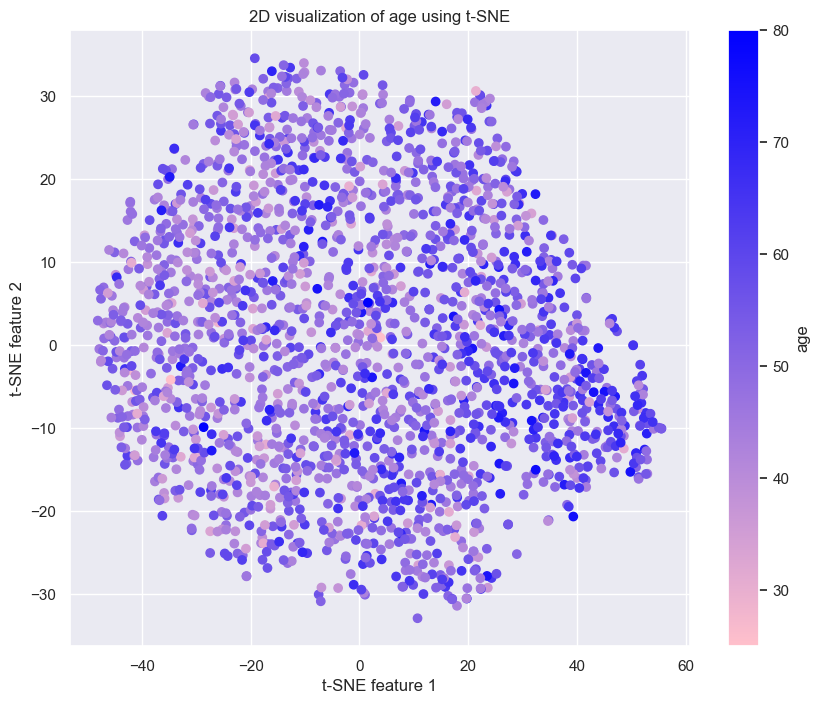

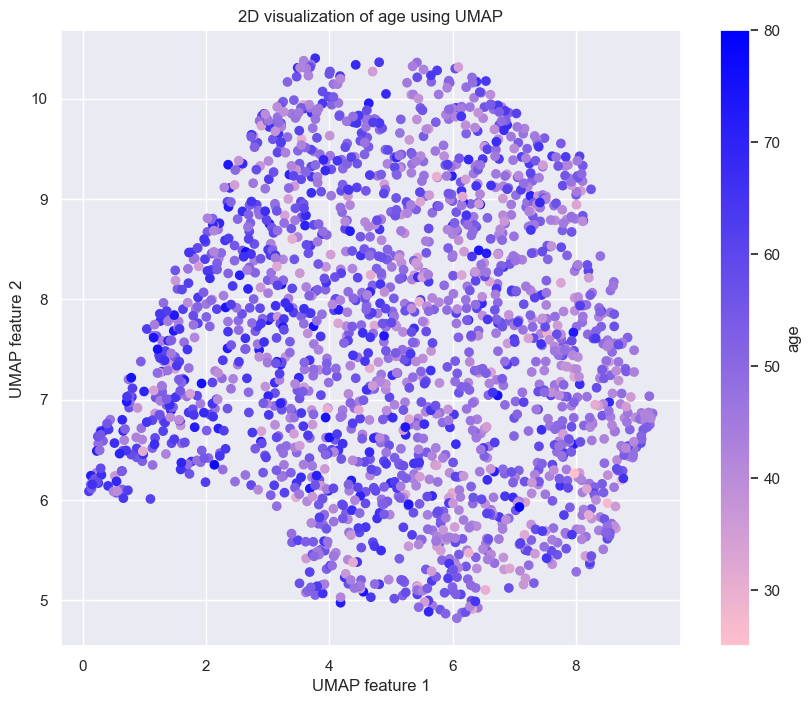

In [23]:
from src.visualize import plot_TSNE, plot_UMAP

var_name = "age"

df_tmp = df_merged[:2000]
df_tmp = df_tmp[df_tmp["HBA1C"] < 15]

# 次元削減してプロット
X_df, y_df = split_dataframe(df_tmp, var_name)
plot_TSNE(X_df, y_df, var_name=var_name, random_state=42)
plot_UMAP(X_df, y_df, var_name=var_name, random_state=42)



# XGBoost

# MLP

In [38]:
import importlib
import src.model.MLP

# モジュールの再読み込み
importlib.reload(src.model.MLP)

# モジュールから必要なクラスや関数をインポート
from src.model.MLP import MLP, train, valid

Epoch 1/10, Train Loss: 0.034220570710022005, Validation Loss: 0.028332518693059684
Epoch 2/10, Train Loss: 0.028919227747246624, Validation Loss: 0.028219284384977072
Epoch 3/10, Train Loss: 0.02894183589378372, Validation Loss: 0.028095995343755932
Epoch 4/10, Train Loss: 0.028645857167430223, Validation Loss: 0.028004821331705898
Epoch 5/10, Train Loss: 0.028575092303799465, Validation Loss: 0.029574277356732636
Epoch 6/10, Train Loss: 0.02838125061825849, Validation Loss: 0.02876264995429665
Epoch 7/10, Train Loss: 0.02836542234290391, Validation Loss: 0.02860756969312206
Epoch 8/10, Train Loss: 0.02821269237319939, Validation Loss: 0.02769860498374328
Epoch 9/10, Train Loss: 0.02808073239866644, Validation Loss: 0.02832106059649959
Epoch 10/10, Train Loss: 0.028096387907862664, Validation Loss: 0.027915113023482263


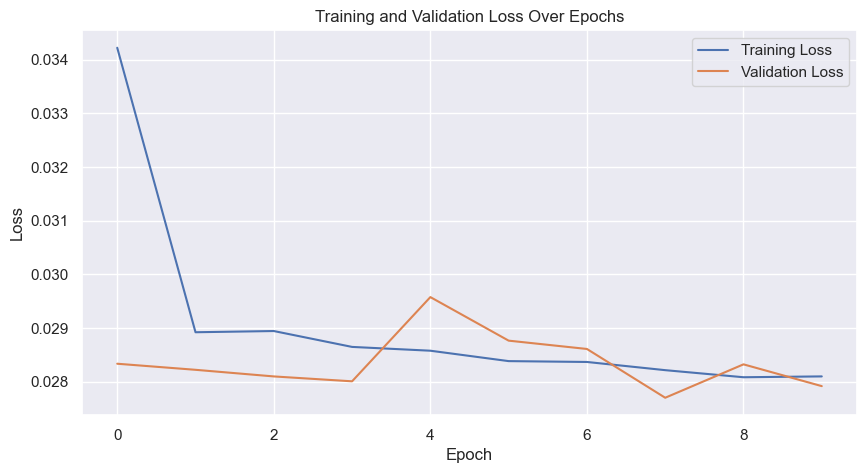

Epoch 1/10, Train Loss: 0.04041339504765347, Validation Loss: 0.0356892951996997
Epoch 2/10, Train Loss: 0.0344114929321222, Validation Loss: 0.03413271470926702
Epoch 3/10, Train Loss: 0.034333160880487414, Validation Loss: 0.03412760859355331
Epoch 4/10, Train Loss: 0.03420643861172721, Validation Loss: 0.03358502818737179
Epoch 5/10, Train Loss: 0.033683034765999764, Validation Loss: 0.03337457433808595
Epoch 6/10, Train Loss: 0.033806552633177486, Validation Loss: 0.0353126544971019
Epoch 7/10, Train Loss: 0.033334765746258196, Validation Loss: 0.03322449675761163
Epoch 8/10, Train Loss: 0.03377147401915863, Validation Loss: 0.03334503269288689
Epoch 9/10, Train Loss: 0.03349198418436572, Validation Loss: 0.03309308243915439
Epoch 10/10, Train Loss: 0.03378836491610855, Validation Loss: 0.033153667324222626


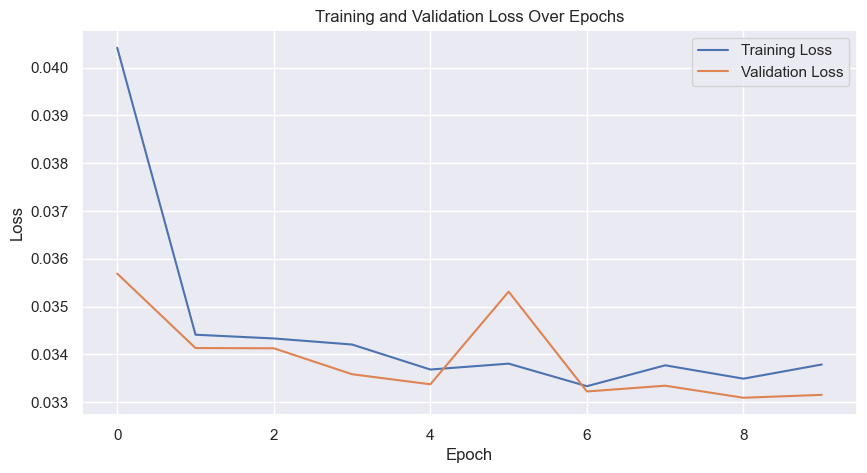

Epoch 1/10, Train Loss: 0.03222249622340314, Validation Loss: 0.03093418509233743
Epoch 2/10, Train Loss: 0.028980824176687747, Validation Loss: 0.02841636633966118
Epoch 3/10, Train Loss: 0.028530993533786388, Validation Loss: 0.028311651735566556
Epoch 4/10, Train Loss: 0.02844956102198921, Validation Loss: 0.02871586096007377
Epoch 5/10, Train Loss: 0.028161947685293853, Validation Loss: 0.028073296044021846
Epoch 6/10, Train Loss: 0.02826213089283556, Validation Loss: 0.028994887531735004
Epoch 7/10, Train Loss: 0.028218531678430737, Validation Loss: 0.02821701264474541
Epoch 8/10, Train Loss: 0.02792223804281093, Validation Loss: 0.02804294372908771
Epoch 9/10, Train Loss: 0.02797416501562111, Validation Loss: 0.027891097101382913
Epoch 10/10, Train Loss: 0.027831482619512828, Validation Loss: 0.027763626142404973


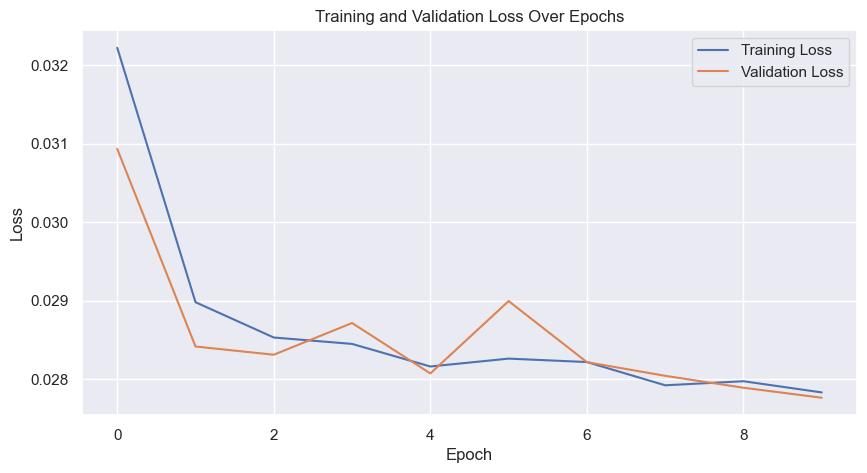

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.model.MLP import MLP, train, valid


# ハイパラ
epochs = 10
dropout_rate = 0
lr = 0.001

# モデルの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"


model_CV = []
for k in range(n_splits):
    model = MLP(input_dim=212, hidden_dims=[100,10], output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # train and valid per epoch
    for epoch in range(epochs):
        # トレーニング
        train_loss = train(model, train_loader_CV[k], optimizer=optimizer, device=device)
        train_losses.append(train_loss)

        # 検証
        val_loss = valid(model, test_loader_CV[k],device=device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # save model per CV
    model_CV.append(model)

    # 損失のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [64]:

y_pred_scaled_CV = []
y_pred_CV = []

for k in range(n_splits):
    X_test = X_test_CV[k].to_numpy()

    # X_testにスケーラーを適用
    X_scaler = X_scaler_CV[k]
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    # テストデータの予測
    model = model_CV[k]
    model.eval()

    y_pred_scaled = model(X_test_scaled)
    y_pred_scaled_CV.append(y_pred_scaled)

    # 予測結果を元に戻す
    y_scaler = y_scaler_CV[k]
    y_pred = y_scaler.inverse_transform(y_pred_scaled.detach().numpy())
    y_pred_CV.append(y_pred)


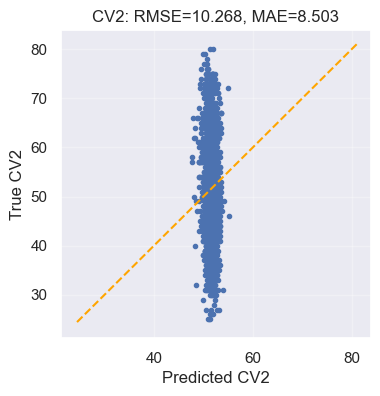

In [65]:
from src.eval_plot import calc_reg_metrics, plot_reg_metrics


k = 2

y_test = y_test_CV[k].to_numpy()
y_scaler = y_scaler_CV[k]
y_test_scaled = y_scaler.transform(y_test)

y_pred_scaled = y_pred_scaled_CV[k].detach().numpy()

calc_reg_metrics(y_test_scaled, y_pred_scaled, y_scaler_CV[0])

plot_reg_metrics(y_test_scaled, y_pred_scaled, y_scaler_CV[0], target_name=f"CV{k}")